In [220]:
import warnings
import numpy as np
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
import xgboost as xgb
import optuna
import plotly.express as px

%matplotlib inline

# First test on Spaceship competition on Kaggle

https://www.kaggle.com/competitions/spaceship-titanic/overview

In [2]:
!ls data/spaceship/

test.csv
train.csv


In [3]:
!head -5 data/spaceship/train.csv

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False


In [66]:
def load_df(path, is_test=False):
    df = pd.read_csv(path)
    df = df.drop(['Cabin', 'Name'], axis=1)
    df = df.set_index('PassengerId')
    for col in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        # fill with mean, will use bayes only on binary features, those are continuous
        df[col] = df[col].fillna(df[col].mean())

    for col in ['HomePlanet', 'Destination']:
        # one-hot encoding
        df = df.join(pd.get_dummies(df[col])).drop([col], axis=1)

    df['Age'] = df['Age'].astype(int)
    if not is_test:
        df['Transported'] = df['Transported'].astype(int)

    return df

In [444]:
train_df = load_df('data/spaceship/train.csv')
test_df = load_df('data/spaceship/test.csv', is_test=True)

In [445]:
len(train_df)

8693

In [446]:
len(test_df)

4277

In [72]:
len(train_df[(train_df['CryoSleep'].isna()) & (train_df['VIP'].isna())])

7

Only 7 instances where both are NaN, I will drop those so one does not interfere with the other inputter

In [76]:
train_df = train_df.drop(train_df[(train_df['CryoSleep'].isna()) & (train_df['VIP'].isna())].index)

In [77]:
train_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,,
0001_01,False,39,False,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1
0002_01,False,24,False,109.0,9.0,25.0,549.0,44.0,1,1,0,0,0,0,1
0003_01,False,58,True,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,0,0,1
0003_02,False,33,False,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,0,0,1
0004_01,False,16,False,303.0,70.0,151.0,565.0,2.0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,False,41,True,0.0,6819.0,0.0,1643.0,74.0,0,0,1,0,1,0,0
9278_01,True,18,False,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0
9279_01,False,26,False,0.0,0.0,1872.0,1.0,0.0,1,1,0,0,0,0,1


In [78]:
test_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,
0013_01,True,27,False,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1
0018_01,False,19,False,0.0,9.0,0.0,2823.0,0.0,1,0,0,0,0,1
0019_01,True,31,False,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0
0021_01,False,38,False,0.0,6652.0,0.0,181.0,585.0,0,1,0,0,0,1
0023_01,False,20,False,10.0,0.0,635.0,0.0,0.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,True,34,False,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1
9269_01,False,42,False,0.0,847.0,17.0,10.0,144.0,1,0,0,0,0,1
9271_01,True,28,False,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0


#### That's the point I want the data before dealing with NaNs in CryoSleep and VIP, will save here

In [81]:
train_df.to_parquet('data/spaceship/parsed_train.parquet')
test_df.to_parquet('data/spaceship/parsed_test.parquet')

---

### Start with a mode filler

In [192]:
train_df = pd.read_parquet('data/spaceship/parsed_train.parquet')
test_df = pd.read_parquet('data/spaceship/parsed_test.parquet')

In [193]:
def fill_with_mode(df):
    for col in ['CryoSleep', 'VIP']:
        df[col] = df[col].fillna(df[col].mode()[0]).astype(int)
    
    return df

In [194]:
train_df = fill_with_mode(train_df)
test_df = fill_with_mode(test_df)

#### Will use as classifiers: Logistic Regression, NaiveBayes, RandomForest, KNN, XGB, optimized KNN, and optimized XGB

In [113]:
def metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{model_name} results:')
    print(f'Accuracy: {acc:.2f}')
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f'F1-Score: {f1:.2f}')
    display(ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot())
    return pd.DataFrame(data={
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1': [f1]
    }, index=[model_name])

In [114]:
res_df = pd.DataFrame()

Will need to normalize numeric features for most classifiers, will use this df only for XGB, so I'll actually start with XGB and then normalize and run the others

In [98]:
len(train_df[train_df['Transported'] == 1]) / len(train_df)

0.5039143449228644

Distribution of y is fine, no need to stratify splits

In [195]:
y = train_df.pop('Transported')
X_train, X_test, y_train, y_test = train_test_split(train_df, y, train_size=0.7, random_state=42)

In [108]:
model = xgb.XGBClassifier()

In [109]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [110]:
model.score(X_train, y_train)

0.8878289473684211

Default XGB results:
Accuracy: 0.79
Precision: 0.77
Recall: 0.83
F1-Score: 0.80


,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745


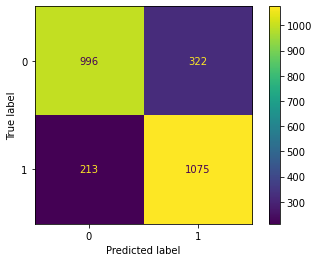

In [115]:
res_df = pd.concat([res_df, metrics(y_test, model.predict(X_test), 'Default XGB')])

#### Optimize XGB

In [131]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [166]:
dtest = xgb.DMatrix(X_test.reset_index(drop=True), label=y_test.reset_index(drop=True))

In [167]:
def objective(trial):
    param = {
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'verbosity': 0,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10)
    }
    scores = []
    for train_index, test_index in KFold(shuffle=True, random_state=42).split(X_train, y_train):
        _X_train, _X_val = X_train.loc[train_index], X_train.loc[test_index]
        _y_train, _y_val = y_train.loc[train_index], y_train.loc[test_index]
        _dtrain = xgb.DMatrix(_X_train, label=_y_train)
        _dvalid = xgb.DMatrix(_X_val, label=_y_val)
        pruner = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')
        booster = xgb.train(param, _dtrain, evals=[(dtest, 'validation')], callbacks=[pruner], verbose_eval=False)
        scores.append(accuracy_score(_y_val, booster.predict(_dvalid).round()))

    return np.mean(scores)

In [168]:
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10, n_warmup_steps=30, interval_steps=10
    )
)
study.optimize(objective, n_trials=300)
study.best_params

[I 2022-06-22 23:42:36,555] A new study created in memory with name: no-name-92f43b4d-ff5f-40ef-9e17-844791d73956
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\a

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-22 23:42:39,109] Trial 15 finished with value: 0.7848684210526315 and parameters: {'booster': 'dart', 'lambda': 2.945241226398033e-07, 'alpha': 2.0124392352585493e-06, 'learning_rate': 0.19716771946708553, 'gamma': 0.0006830755867523889, 'n_estimators': 273, 'max_depth': 10, 'min_child_weight': 2.280101280876875}. Best is trial 3 with value: 0.7873355263157895.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value 

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-22 23:42:44,087] Trial 41 finished with value: 0.7661184210526316 and parameters: {'booster': 'dart', 'lambda': 5.219689750861285e-06, 'alpha': 0.0004475354352992215, 'learning_rate': 0.9739517170348433, 'gamma': 11.19417305084155, 'n_estimators': 431, 'max_depth': 1, 'min_child_weight': 3.100563763598209}. Best is trial 37 with value: 0.7893092105263159.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ign

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-22 23:43:06,360] Trial 232 finished with value: 0.793092105263158 and parameters: {'booster': 'gblinear', 'lambda': 0.0065941499660303006, 'alpha': 0.0046245068953266475, 'learning_rate': 0.9122653519433196, 'gamma': 0.0001078389625311741, 'n_estimators': 259, 'max_depth': 8, 'min_child_weight': 9.96172014802717}. Best is trial 192 with value: 0.7947368421052632.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported valu

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[I 2022-06-22 23:43:07,172] Trial 239 finished with value: 0.793092105263158 and parameters: {'booster': 'gblinear', 'lambda': 0.010027781911755797, 'alpha': 0.0036947021308919954, 'learning_rate': 0.8290781968696831, 'gamma': 3.484494183883017e-05, 'n_estimators': 211, 'max_depth': 8, 'min_child_weight': 8.071277451754987}. Best is trial 192 with value: 0.7947368421052632.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported valu

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-22 23:43:14,548] Trial 298 finished with value: 0.792763157894737 and parameters: {'booster': 'gblinear', 'lambda': 0.008608833945724264, 'alpha': 0.001924410145502874, 'learning_rate': 0.8496976126244962, 'gamma': 48.05631122879844, 'n_estimators': 225, 'max_depth': 10, 'min_child_weight': 7.5949857449531395}. Best is trial 192 with value: 0.7947368421052632.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value i

{'booster': 'gblinear',
 'lambda': 0.010259484832454235,
 'alpha': 0.0025521123491868596,
 'learning_rate': 0.9217777160661896,
 'gamma': 6.574616424932138e-05,
 'n_estimators': 232,
 'max_depth': 10,
 'min_child_weight': 8.694381120880017}

In [169]:
model = xgb.XGBClassifier(**{
    'booster': 'gblinear',
    'lambda': 0.010259484832454235,
    'alpha': 0.0025521123491868596,
    'learning_rate': 0.9217777160661896,
    'gamma': 6.574616424932138e-05,
    'n_estimators': 232,
    'max_depth': 10,
    'min_child_weight': 8.694381120880017
})

In [170]:
model.fit(X_train, y_train)

XGBClassifier(alpha=0.0025521123491868596, base_score=0.5, booster='gblinear',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=6.574616424932138e-05, gpu_id=-1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.010259484832454235, learning_rate=0.9217777160661896,
              max_bin=None, max_cat_to_onehot=None, max_delta_step=None,
              max_depth=10, max_leaves=None, min_child_weight=8.694381120880017,
              missing=nan, monotone_constraints=None, n_estimators=232,
              n_jobs=0, num_parallel_tree=None, predictor=None, random_state=0, ...)

In [171]:
model.score(X_train, y_train)

0.7955592105263158

Optuna XGB results:
Accuracy: 0.79
Precision: 0.75
Recall: 0.88
F1-Score: 0.81


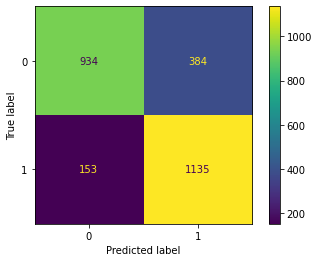

In [173]:
res_df = pd.concat([res_df, metrics(y_test, model.predict(X_test), 'Optuna XGB')])

In [174]:
res_df

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Optuna XGB,0.793937,0.747202,0.881211,0.808693


#### Time to normalize features and run the other classifiers

In [178]:
cols_to_scale = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
scaler = StandardScaler()
scaler.fit(pd.concat([train_df, test_df])[cols_to_scale])

StandardScaler()

In [196]:
def scale(df):
    df[cols_to_scale] = pd.DataFrame(scaler.transform(df[cols_to_scale]), columns=cols_to_scale, index=df.index)
    return df

In [199]:
train_df = scale(train_df)
test_df = scale(test_df)

In [205]:
train_df = train_df.reset_index(drop=True)
y = y.reset_index(drop=True)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, train_size=0.7, random_state=42)

#### Fitting the other classifiers

##### Logistic Regression

In [213]:
classifier = LogisticRegression()

In [214]:
classifier.fit(X_train, y_train)

LogisticRegression()

In [215]:
classifier.score(X_train, y_train)

0.7087171052631579

Logistic Regression results:
Accuracy: 0.73
Precision: 0.77
Recall: 0.64
F1-Score: 0.70


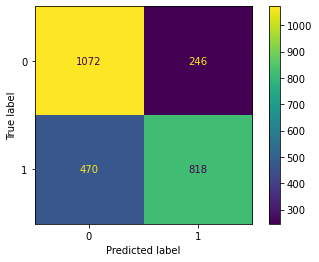

In [218]:
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Logistic Regression')])

In [219]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Logistic Regression,0.725249,0.768797,0.635093,0.695578


##### Naive Bayes

In [233]:
classifier = GaussianNB()

In [234]:
classifier.fit(X_train, y_train)

GaussianNB()

In [235]:
classifier.score(X_train, y_train)

0.7050986842105263

Naive Bayes results:
Accuracy: 0.71
Precision: 0.64
Recall: 0.92
F1-Score: 0.76


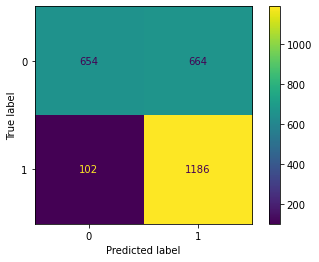

In [236]:
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Naive Bayes')])

In [237]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


##### Random Forest

In [238]:
classifier = RandomForestClassifier()

In [239]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [240]:
classifier.score(X_train, y_train)

0.940625

Random Forest results:
Accuracy: 0.79
Precision: 0.78
Recall: 0.80
F1-Score: 0.79


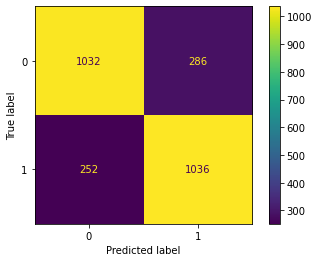

In [241]:
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Random Forest')])

In [242]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


##### KNN

In [243]:
classifier = KNeighborsClassifier()

In [244]:
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [245]:
classifier.score(X_train, y_train)

0.7930921052631579

KNN results:
Accuracy: 0.73
Precision: 0.73
Recall: 0.72
F1-Score: 0.72


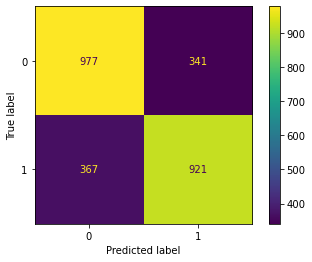

In [246]:
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'KNN')])

In [247]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


##### Optuna KNN

In [256]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [257]:
def objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 100),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
    }
    scores = []
    for train_index, test_index in KFold(shuffle=True, random_state=42).split(X_train, y_train):
        _X_train, _X_val = X_train.loc[train_index], X_train.loc[test_index]
        _y_train, _y_val = y_train.loc[train_index], y_train.loc[test_index]
        knn = KNeighborsClassifier(**param)
        knn.fit(_X_train, _y_train)
        scores.append(accuracy_score(_y_val, knn.predict(_X_val)))

    return np.mean(scores)

In [258]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

[I 2022-06-23 00:05:36,018] A new study created in memory with name: no-name-2b259813-0ab2-46bb-a64a-68308062766c
[I 2022-06-23 00:05:36,380] Trial 0 finished with value: 0.6973684210526316 and parameters: {'n_neighbors': 3, 'weights': 'uniform'}. Best is trial 0 with value: 0.6973684210526316.
[I 2022-06-23 00:05:36,805] Trial 1 finished with value: 0.727796052631579 and parameters: {'n_neighbors': 36, 'weights': 'uniform'}. Best is trial 1 with value: 0.727796052631579.
[I 2022-06-23 00:05:37,250] Trial 2 finished with value: 0.7261513157894737 and parameters: {'n_neighbors': 47, 'weights': 'uniform'}. Best is trial 1 with value: 0.727796052631579.
[I 2022-06-23 00:05:37,569] Trial 3 finished with value: 0.7126644736842105 and parameters: {'n_neighbors': 42, 'weights': 'distance'}. Best is trial 1 with value: 0.727796052631579.
[I 2022-06-23 00:05:37,996] Trial 4 finished with value: 0.7141447368421053 and parameters: {'n_neighbors': 98, 'weights': 'distance'}. Best is trial 1 with v

[I 2022-06-23 00:05:53,310] Trial 41 finished with value: 0.7277960526315789 and parameters: {'n_neighbors': 29, 'weights': 'uniform'}. Best is trial 32 with value: 0.7302631578947368.
[I 2022-06-23 00:05:53,756] Trial 42 finished with value: 0.7294407894736843 and parameters: {'n_neighbors': 42, 'weights': 'uniform'}. Best is trial 32 with value: 0.7302631578947368.
[I 2022-06-23 00:05:54,189] Trial 43 finished with value: 0.7300986842105263 and parameters: {'n_neighbors': 40, 'weights': 'uniform'}. Best is trial 32 with value: 0.7302631578947368.
[I 2022-06-23 00:05:54,625] Trial 44 finished with value: 0.7299342105263158 and parameters: {'n_neighbors': 38, 'weights': 'uniform'}. Best is trial 32 with value: 0.7302631578947368.
[I 2022-06-23 00:05:55,028] Trial 45 finished with value: 0.730592105263158 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 45 with value: 0.730592105263158.
[I 2022-06-23 00:05:55,292] Trial 46 finished with value: 0.7013157894736842 

[I 2022-06-23 00:06:09,999] Trial 83 finished with value: 0.7115131578947368 and parameters: {'n_neighbors': 9, 'weights': 'uniform'}. Best is trial 50 with value: 0.7315789473684211.
[I 2022-06-23 00:06:10,388] Trial 84 finished with value: 0.7266447368421053 and parameters: {'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 50 with value: 0.7315789473684211.
[I 2022-06-23 00:06:10,792] Trial 85 finished with value: 0.730592105263158 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 50 with value: 0.7315789473684211.
[I 2022-06-23 00:06:11,193] Trial 86 finished with value: 0.7268092105263158 and parameters: {'n_neighbors': 20, 'weights': 'uniform'}. Best is trial 50 with value: 0.7315789473684211.
[I 2022-06-23 00:06:11,572] Trial 87 finished with value: 0.6947368421052632 and parameters: {'n_neighbors': 4, 'weights': 'uniform'}. Best is trial 50 with value: 0.7315789473684211.
[I 2022-06-23 00:06:11,986] Trial 88 finished with value: 0.7310855263157895 a

{'n_neighbors': 17, 'weights': 'uniform'}

In [259]:
classifier = KNeighborsClassifier(**{
    'n_neighbors': 17,
    'weights': 'uniform'
})

In [260]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [261]:
classifier.score(X_train, y_train)

0.7598684210526315

Optuna KNN results:
Accuracy: 0.75
Precision: 0.79
Recall: 0.68
F1-Score: 0.73


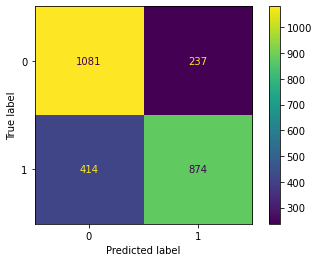

In [262]:
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Optuna KNN')])

In [263]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


Best results were default XGB, so will make a first submission using default XGB with unnormalized dataset

In [264]:
train_df = pd.read_parquet('data/spaceship/parsed_train.parquet')
test_df = pd.read_parquet('data/spaceship/parsed_test.parquet')
train_df = fill_with_mode(train_df)
test_df = fill_with_mode(test_df)
y = train_df.pop('Transported')

In [268]:
model = xgb.XGBClassifier()

In [269]:
model.fit(train_df, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [272]:
sub = pd.DataFrame(data={'Transported': model.predict(test_df)}, index=test_df.index)
sub['Transported'] = sub['Transported'].astype(bool)

In [277]:
len(sub[sub['Transported']]) / len(sub)

0.5209258826280103

seems good

In [276]:
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True


In [278]:
sub.to_csv('results/spaceship/mode_fill_default_xgb.csv')

Test Score = 0.78536

Let's see optuna XGB

In [279]:
model = xgb.XGBClassifier(**{
    'booster': 'gblinear',
    'lambda': 0.010259484832454235,
    'alpha': 0.0025521123491868596,
    'learning_rate': 0.9217777160661896,
    'gamma': 6.574616424932138e-05,
    'n_estimators': 232,
    'max_depth': 10,
    'min_child_weight': 8.694381120880017
})

In [280]:
model.fit(train_df, y)

XGBClassifier(alpha=0.0025521123491868596, base_score=0.5, booster='gblinear',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=6.574616424932138e-05, gpu_id=-1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.010259484832454235, learning_rate=0.9217777160661896,
              max_bin=None, max_cat_to_onehot=None, max_delta_step=None,
              max_depth=10, max_leaves=None, min_child_weight=8.694381120880017,
              missing=nan, monotone_constraints=None, n_estimators=232,
              n_jobs=0, num_parallel_tree=None, predictor=None, random_state=0, ...)

In [281]:
sub = pd.DataFrame(data={'Transported': model.predict(test_df)}, index=test_df.index)
sub['Transported'] = sub['Transported'].astype(bool)

In [282]:
len(sub[sub['Transported']]) / len(sub)

0.5660509703062895

In [283]:
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True


In [284]:
sub.to_csv('results/spaceship/mode_fill_optuna_xgb.csv')

Test score: 0.78793

Slightly better

### Training Naive Bayes Classifier to fill NaNs in binary features

In [285]:
train_df = pd.read_parquet('data/spaceship/parsed_train.parquet')
test_df = pd.read_parquet('data/spaceship/parsed_test.parquet')

Will scale first

In [289]:
train_df = scale(train_df)
test_df = scale(test_df)

In [301]:
test_df[test_df['CryoSleep'].isna() & test_df['VIP'].isna()]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,
4776_02,None,-0.404469,None,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,0,1,0,0,1
8601_01,None,1.703352,None,-0.327502,-0.288464,-0.219248,-0.275946,0.377980,1,0,0,0,0,1


Can't drop those two cause I'll have to predict them, so I'll fill only those with mode only on column VIP

In [302]:
test_df.loc[test_df['CryoSleep'].isna() & test_df['VIP'].isna(), 'VIP'] = test_df['VIP'].mode()[0]

In [304]:
test_df.loc[['4776_02', '8601_01']]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,
4776_02,None,-0.404469,False,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,0,1,0,0,1
8601_01,None,1.703352,False,-0.327502,-0.288464,-0.219248,-0.275946,0.377980,1,0,0,0,0,1


In [329]:
def bayes_fill_na(df, cols):
    for col in cols:
        aux_df = df.copy()
        print(f'Running {col=}')
        for not_col in [c for c in cols if c != col]:
            # will have to fill other cols with mode to make classifier for col
            aux_df[not_col] = aux_df[not_col].fillna(aux_df[not_col].mode()[0]).astype(int)

        train, test = aux_df[~df[col].isna()].copy(), aux_df[aux_df[col].isna()].copy()
        y_train = train.pop(col).astype(int)
        test.pop(col)

        classifier = GaussianNB()
        classifier.fit(train, y_train)
        print(f'Classifier score on col {col} = {classifier.score(train, y_train):.2f}')

        train[col] = y_train
        df.loc[test.index, col] = classifier.predict(test).astype(bool)
    
    return df

In [330]:
df = bayes_fill_na(pd.concat([train_df, test_df]).drop(['Transported'], axis=1), ['CryoSleep', 'VIP'])

Running col='CryoSleep'
Classifier score on col CryoSleep = 0.91
Running col='VIP'
Classifier score on col VIP = 0.62


In [334]:
train_df[['CryoSleep', 'VIP']] = df.loc[train_df.index, ['CryoSleep', 'VIP']]
test_df[['CryoSleep', 'VIP']] = df.loc[test_df.index, ['CryoSleep', 'VIP']]

In [341]:
train_df[['CryoSleep', 'VIP']] = train_df[['CryoSleep', 'VIP']].astype(int)
test_df[['CryoSleep', 'VIP']] = test_df[['CryoSleep', 'VIP']].astype(int)

In [342]:
train_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,,
0001_01,0,0.719702,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,0,1,0,0,0,1
0002_01,0,-0.334209,0,-0.177765,-0.282720,-0.256940,0.215102,-0.224876,1,1,0,0,0,0,1
0003_01,0,2.054655,1,-0.280709,1.993878,-0.299772,5.730226,-0.220594,0,0,1,0,0,0,1
0003_02,0,0.298138,0,-0.347779,0.530396,0.335855,2.701648,-0.097283,0,0,1,0,0,0,1
0004_01,0,-0.896294,0,0.124829,-0.243788,-0.041067,0.229413,-0.260842,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0,0.860223,1,-0.347779,4.063686,-0.299772,1.193620,-0.199186,0,0,1,0,1,0,0
9278_01,1,-0.755773,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,1,0,0,0,1,0
9279_01,0,-0.193687,0,-0.347779,-0.288464,2.907488,-0.275052,-0.262554,1,1,0,0,0,0,1


In [343]:
test_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,
0013_01,1,-0.123426,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,1,0,0,0,0,1
0018_01,0,-0.685512,0,-0.347779,-0.282720,-0.299772,2.249061,-0.262554,1,0,0,0,0,1
0019_01,1,0.157616,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,1,0,1,0,0
0021_01,0,0.649441,0,-0.347779,3.957100,-0.299772,-0.114052,0.238398,0,1,0,0,0,1
0023_01,0,-0.615251,0,-0.332182,-0.288464,0.788161,-0.275946,-0.262554,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,1,0.368398,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,1,0,0,0,0,1
9269_01,0,0.930484,0,-0.347779,0.252124,-0.270647,-0.267002,-0.139243,1,0,0,0,0,1
9271_01,1,-0.053166,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,0,1,1,0,0


#### Check difference from mode method

In [441]:
train_df2 = pd.read_parquet('data/spaceship/parsed_train.parquet')
test_df2 = pd.read_parquet('data/spaceship/parsed_test.parquet')

In [364]:
len(train_df2[train_df2['CryoSleep'].isna()]), len(test_df2[test_df2['CryoSleep'].isna()])

(210, 93)

In [365]:
len(train_df2[train_df2['VIP'].isna()]), len(test_df2[test_df2['VIP'].isna()])

(196, 93)

In [366]:
train_df2 = fill_with_mode(train_df2)
test_df2 = fill_with_mode(test_df2)

In [367]:
len(train_df[train_df['CryoSleep'] != train_df2['CryoSleep']]), len(test_df[test_df['CryoSleep'] != test_df2['CryoSleep']])

(87, 36)

In [368]:
len(train_df[train_df['VIP'] != train_df2['VIP']]), len(test_df[test_df['VIP'] != test_df2['VIP']])

(78, 43)

In [369]:
len(train_df)

8686

In [370]:
210 / 8686

0.02417683628827999

2.4% missing CryoSleep

In [442]:
196 / 8686

0.022565047202394658

2.3% missing VIP

In [371]:
87 / 8686

0.010016117890858853

In [443]:
78 / 8686

0.008979967764218283

1% got a different label from naive bayes

Clearly some labels have changed, time to see the actual impact

In [379]:
train_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0,0.719702,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,0,1,0,0,0,1
1,0,-0.334209,0,-0.177765,-0.282720,-0.256940,0.215102,-0.224876,1,0,0,0,0,1
2,0,2.054655,1,-0.280709,1.993878,-0.299772,5.730226,-0.220594,0,1,0,0,0,1
3,0,0.298138,0,-0.347779,0.530396,0.335855,2.701648,-0.097283,0,1,0,0,0,1
4,0,-0.896294,0,0.124829,-0.243788,-0.041067,0.229413,-0.260842,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8681,0,0.860223,1,-0.347779,4.063686,-0.299772,1.193620,-0.199186,0,1,0,1,0,0
8682,1,-0.755773,0,-0.347779,-0.288464,-0.299772,-0.275946,-0.262554,1,0,0,0,1,0
8683,0,-0.193687,0,-0.347779,-0.288464,2.907488,-0.275052,-0.262554,1,0,0,0,0,1
8684,0,0.227877,0,-0.347779,0.381048,-0.299772,0.039792,2.507671,0,1,0,1,0,0


In [375]:
y = train_df.pop('Transported')

In [378]:
train_df = train_df.reset_index(drop=True)
y = y.reset_index(drop=True)

In [381]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, train_size=0.7, random_state=42)

##### Default XGB

Train score: 0.8930921052631579
Default XGB Bayes Fill results:
Accuracy: 0.79
Precision: 0.77
Recall: 0.84
F1-Score: 0.80


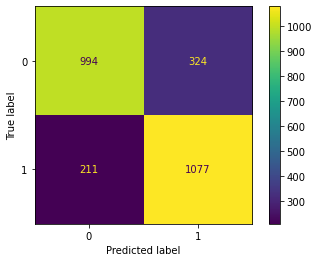

In [387]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print('Train score:', model.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, model.predict(X_test), 'Default XGB Bayes Fill')])

In [388]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


Accuracy was the same but F1 was slighly better

##### Optuna XGB (same params)

Train score: 0.7779605263157895
Optuna XGB Bayes Fill results:
Accuracy: 0.79
Precision: 0.78
Recall: 0.81
F1-Score: 0.79


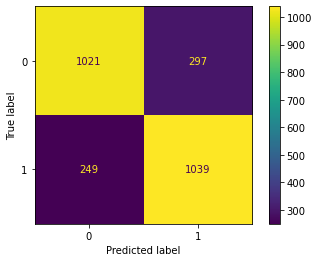

In [389]:
model = xgb.XGBClassifier(**{
    'booster': 'gblinear',
    'lambda': 0.010259484832454235,
    'alpha': 0.0025521123491868596,
    'learning_rate': 0.9217777160661896,
    'gamma': 6.574616424932138e-05,
    'n_estimators': 232,
    'max_depth': 10,
    'min_child_weight': 8.694381120880017
})
model.fit(X_train, y_train)
print('Train score:', model.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, model.predict(X_test), 'Optuna XGB Bayes Fill')])

In [390]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


This actually got worse

##### Logistic Regression

Train score: 0.7853618421052632
Logistic Regression Bayes Fill results:
Accuracy: 0.79
Precision: 0.77
Recall: 0.84
F1-Score: 0.80


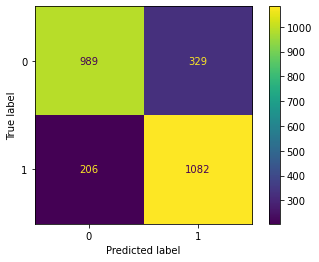

In [391]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Train score:', classifier.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Logistic Regression Bayes Fill')])

In [392]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes,0.706063,0.641081,0.920807,0.755895


Big Difference Here

##### Naive Bayes

Train score: 0.7133223684210527
Naive Bayes Bayes Fill results:
Accuracy: 0.71
Precision: 0.65
Recall: 0.93
F1-Score: 0.76


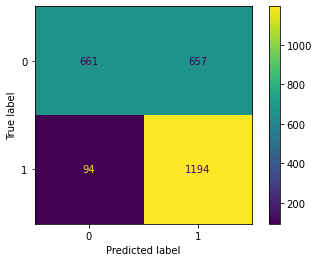

In [393]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
print('Train score:', classifier.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Naive Bayes Bayes Fill')])

In [394]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578
Naive Bayes Bayes Fill,0.711819,0.645057,0.927019,0.760752


Slightly Better

##### Random Forest

Train score: 0.9401315789473684
Random Forest Bayes Fill results:
Accuracy: 0.79
Precision: 0.78
Recall: 0.80
F1-Score: 0.79


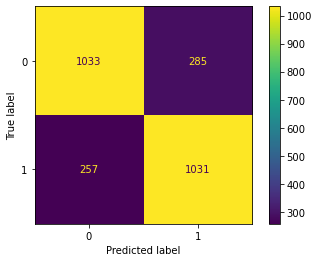

In [395]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
print('Train score:', classifier.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Random Forest Bayes Fill')])

In [396]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Random Forest Bayes Fill,0.792018,0.783435,0.800466,0.791859
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353
Logistic Regression,0.725249,0.768797,0.635093,0.695578


Slightly worse

##### KNN

Train score: 0.8235197368421052
KNN Bayes Fill results:
Accuracy: 0.77
Precision: 0.75
Recall: 0.80
F1-Score: 0.77


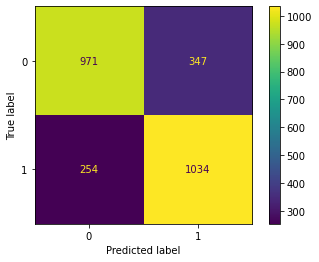

In [397]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
print('Train score:', classifier.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'KNN Bayes Fill')])

In [398]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Random Forest Bayes Fill,0.792018,0.783435,0.800466,0.791859
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921
KNN Bayes Fill,0.769378,0.748733,0.802795,0.774822
Optuna KNN,0.750192,0.786679,0.678571,0.728637
KNN,0.728319,0.729794,0.715062,0.722353


Considerably Better

##### Optuna KNN

Train score: 0.8018092105263158
Optuna KNN Bayes Fill results:
Accuracy: 0.79
Precision: 0.77
Recall: 0.83
F1-Score: 0.79


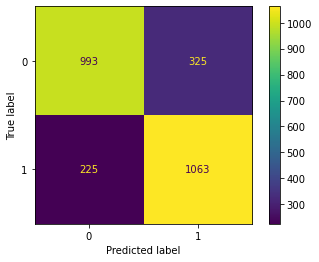

In [399]:
classifier = KNeighborsClassifier(**{
    'n_neighbors': 17,
    'weights': 'uniform'
})
classifier.fit(X_train, y_train)
print('Train score:', classifier.score(X_train, y_train))
res_df = pd.concat([res_df, metrics(y_test, classifier.predict(X_test), 'Optuna KNN Bayes Fill')])

In [400]:
res_df.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
Default XGB,0.794705,0.769506,0.834627,0.800745
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041
Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778
Optuna XGB,0.793937,0.747202,0.881211,0.808693
Random Forest,0.793553,0.783661,0.804348,0.793870
Random Forest Bayes Fill,0.792018,0.783435,0.800466,0.791859
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921
Optuna KNN Bayes Fill,0.788949,0.765850,0.825311,0.794469
KNN Bayes Fill,0.769378,0.748733,0.802795,0.774822
Optuna KNN,0.750192,0.786679,0.678571,0.728637


Considerably better

- Default XGB -> No diff
- Optuna XGB -> Slightly worse
- Logistic Regression -> Much better
- Naive Bayes -> Slightly better
- Random Forest -> No diff
- KNN -> Considerably better

#### Make new sub

Will try default and optuna xgb to compare with previous submissions, will also submit both dataset versions with logistic regression to see actual diff in test

In [403]:
model = xgb.XGBClassifier()
model.fit(train_df, y)
sub = pd.DataFrame(data={'Transported': model.predict(test_df)}, index=test_df.index)
sub['Transported'] = sub['Transported'].astype(bool)
len(sub[sub['Transported']]) / len(sub)

0.5279401449614216

In [404]:
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True


In [405]:
sub.to_csv('results/spaceship/bayes_fill_default_xgb.csv')

Test Score: 0.78489

Slightly worse than previous test score on default xgb, which is in line with the training results

In [406]:
model = xgb.XGBClassifier(**{
    'booster': 'gblinear',
    'lambda': 0.010259484832454235,
    'alpha': 0.0025521123491868596,
    'learning_rate': 0.9217777160661896,
    'gamma': 6.574616424932138e-05,
    'n_estimators': 232,
    'max_depth': 10,
    'min_child_weight': 8.694381120880017
})
model.fit(train_df, y)
sub = pd.DataFrame(data={'Transported': model.predict(test_df)}, index=test_df.index)
sub['Transported'] = sub['Transported'].astype(bool)
len(sub[sub['Transported']]) / len(sub)

0.4921674070610241

This seems to have changed quite a bit

In [407]:
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False
...,...
9266_02,True
9269_01,False
9271_01,True


In [408]:
sub.to_csv('results/spaceship/bayes_fill_optuna_xgb.csv')

Test Score: 0.78466

Worst score I got so far

##### Logistic regression

In [409]:
classifier = LogisticRegression()
classifier.fit(train_df, y)
sub = pd.DataFrame(data={'Transported': classifier.predict(test_df)}, index=test_df.index)
sub['Transported'] = sub['Transported'].astype(bool)
len(sub[sub['Transported']]) / len(sub)

0.5178863689501987

In [410]:
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False
...,...
9266_02,True
9269_01,False
9271_01,True


In [411]:
sub.to_csv('results/spaceship/bayes_fill_log_res.csv')

Test Score: 0.78840

Best score so far, will load dataset again with mode fill and re-train log res

In [412]:
train_df = pd.read_parquet('data/spaceship/parsed_train.parquet')
test_df = pd.read_parquet('data/spaceship/parsed_test.parquet')
train_df = fill_with_mode(train_df)
test_df = fill_with_mode(test_df)
y = train_df.pop('Transported')

In [413]:
classifier = LogisticRegression()
classifier.fit(train_df, y)
sub = pd.DataFrame(data={'Transported': classifier.predict(test_df)}, index=test_df.index)
sub['Transported'] = sub['Transported'].astype(bool)
len(sub[sub['Transported']]) / len(sub)

C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5118073415945756

In [414]:
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False
...,...
9266_02,True
9269_01,False
9271_01,True


In [415]:
sub.to_csv('results/spaceship/mode_fill_log_res.csv')

Test Score: 0.78185

Worst of all

In [419]:
res_df['Test Score'] = pd.Series({
    'Default XGB': 0.78536,
    'Optuna XGB': 0.78793,
    'Logistic Regression': 0.78185,
    'Default XGB Bayes Fill': 0.78489,
    'Optuna XGB Bayes Fill': 0.78466,
    'Logistic Regression Bayes Fill': 0.78840
})

In [420]:
res_df

,Accuracy,Precision,Recall,F1,Test Score
Default XGB,0.794705,0.769506,0.834627,0.800745,0.78536
Optuna XGB,0.793937,0.747202,0.881211,0.808693,0.78793
Logistic Regression,0.725249,0.768797,0.635093,0.695578,0.78185
Naive Bayes,0.706063,0.641081,0.920807,0.755895,NaN
Random Forest,0.793553,0.783661,0.804348,0.793870,NaN
KNN,0.728319,0.729794,0.715062,0.722353,NaN
Optuna KNN,0.750192,0.786679,0.678571,0.728637,NaN
Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041,0.78489
Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921,0.78466
Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778,0.78840


In [424]:
aux = res_df.sort_values('Test Score').reset_index().dropna()
aux['Fill Type'] = aux['index'].str.endswith('Bayes Fill').map(lambda b: 'Bayes' if b else 'Mode')

In [428]:
aux

,index,Accuracy,Precision,Recall,F1,Test Score,Fill Type
0,Logistic Regression,0.725249,0.768797,0.635093,0.695578,0.78185,Mode
1,Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921,0.78466,Bayes
2,Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041,0.78489,Bayes
3,Default XGB,0.794705,0.769506,0.834627,0.800745,0.78536,Mode
4,Optuna XGB,0.793937,0.747202,0.881211,0.808693,0.78793,Mode
5,Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778,0.78840,Bayes


In [429]:
px.bar(aux, x='index', y='Test Score', color='Fill Type', range_y=[0.78, 0.79])

In [434]:
aux = res_df.sort_values('Accuracy', ascending=False).reset_index()
aux['Fill Type'] = aux['index'].str.endswith('Bayes Fill').map(lambda b: 'Bayes' if b else 'Mode')

In [435]:
aux

,index,Accuracy,Precision,Recall,F1,Test Score,Fill Type
0,Default XGB,0.794705,0.769506,0.834627,0.800745,0.78536,Mode
1,Default XGB Bayes Fill,0.794705,0.768737,0.836180,0.801041,0.78489,Bayes
2,Logistic Regression Bayes Fill,0.794705,0.766832,0.840062,0.801778,0.78840,Bayes
3,Optuna XGB,0.793937,0.747202,0.881211,0.808693,0.78793,Mode
4,Random Forest,0.793553,0.783661,0.804348,0.793870,NaN,Mode
5,Random Forest Bayes Fill,0.792018,0.783435,0.800466,0.791859,NaN,Bayes
6,Optuna XGB Bayes Fill,0.790483,0.777695,0.806677,0.791921,0.78466,Bayes
7,Optuna KNN Bayes Fill,0.788949,0.765850,0.825311,0.794469,NaN,Bayes
8,KNN Bayes Fill,0.769378,0.748733,0.802795,0.774822,NaN,Bayes
9,Optuna KNN,0.750192,0.786679,0.678571,0.728637,NaN,Mode


In [440]:
print(aux.to_latex())

\begin{tabular}{llrrrrrl}
\toprule
{} &                           index &  Accuracy &  Precision &    Recall &        F1 &  Test Score & Fill Type \\
\midrule
0  &                     Default XGB &  0.794705 &   0.769506 &  0.834627 &  0.800745 &     0.78536 &      Mode \\
1  &          Default XGB Bayes Fill &  0.794705 &   0.768737 &  0.836180 &  0.801041 &     0.78489 &     Bayes \\
2  &  Logistic Regression Bayes Fill &  0.794705 &   0.766832 &  0.840062 &  0.801778 &     0.78840 &     Bayes \\
3  &                      Optuna XGB &  0.793937 &   0.747202 &  0.881211 &  0.808693 &     0.78793 &      Mode \\
4  &                   Random Forest &  0.793553 &   0.783661 &  0.804348 &  0.793870 &         NaN &      Mode \\
5  &        Random Forest Bayes Fill &  0.792018 &   0.783435 &  0.800466 &  0.791859 &         NaN &     Bayes \\
6  &           Optuna XGB Bayes Fill &  0.790483 &   0.777695 &  0.806677 &  0.791921 &     0.78466 &     Bayes \\
7  &           Optuna KNN Bayes Fill

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18592\1133409500.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [436]:
px.bar(aux, x='index', y='Accuracy', color='Fill Type', range_y=[0.7, 0.8])

In [439]:
px.bar(aux, x='index', y='F1', color='Fill Type', range_y=[0.69, 0.81])